In [8]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('merged_prices.csv')

# Display basic info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                 Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                 --------------  ----- 
 0   day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss  30000 non-null  object
dtypes: object(1)
memory usage: 234.5+ KB


(None,
   day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
 0  -2,0,SQUID_INK,1998,26,,,,,2002,26,,,,,2000.0,0.0                                                                                                                                                   
 1  -2,100,SQUID_INK,1999,5,1998.0,26.0,,,2001,20,...                                                                                                                                                   
 2  -2,200,SQUID_INK,1997,31,,,,,2000,1,2001.0,30....                                                                                                                                                   
 3  -2,300,SQUID_INK,1997,27,,,,,2000,27,,,,,1998....                                                                                                                                        

In [9]:
# Split the single column into multiple columns by comma
df = df.iloc[:, 0].str.split(",", expand=True)

# Show the first few rows and inferred column count
df.columns = [
    "day", "timestamp", "product",
    "bid_price_1", "bid_volume_1",
    "bid_price_2", "bid_volume_2",
    "bid_price_3", "bid_volume_3",
    "ask_price_1", "ask_volume_1",
    "ask_price_2", "ask_volume_2",
    "ask_price_3", "ask_volume_3",
    "mid_price", "profit_and_loss"
]

df.head()


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,SQUID_INK,1998,26,,,,,2002,26,,,,,2000.0,0.0
1,-2,100,SQUID_INK,1999,5,1998.0,26.0,,,2001,20,,,,,2000.0,0.0
2,-2,200,SQUID_INK,1997,31,,,,,2000,1,2001.0,30.0,,,1998.5,0.0
3,-2,300,SQUID_INK,1997,27,,,,,2000,27,,,,,1998.5,0.0
4,-2,400,SQUID_INK,1996,20,,,,,2000,20,,,,,1998.0,0.0


In [10]:
# Convert relevant columns to numeric types
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
df["mid_price"] = pd.to_numeric(df["mid_price"], errors="coerce")
df["profit_and_loss"] = pd.to_numeric(df["profit_and_loss"], errors="coerce")

# Drop rows with missing mid_price or timestamp
df = df.dropna(subset=["timestamp", "mid_price"])

# Filter only SQUID_INK (if other products are present in the full file)
squid_df = df[df["product"] == "SQUID_INK"].copy()

# Show summary
squid_df[["timestamp", "mid_price", "profit_and_loss"]].describe()


,timestamp,mid_price,profit_and_loss
count,30000.000000,30000.000000,30000.0
mean,499950.000000,1971.111767,0.0
std,288679.944524,67.896204,0.0
min,0.000000,1810.500000,0.0
25%,249975.000000,1936.500000,0.0
50%,499950.000000,1965.000000,0.0
75%,749925.000000,1999.500000,0.0
max,999900.000000,2187.500000,0.0


In [ ]:
mean = squid_df["mid_price"].mean()
std = squid_df["mid_price"].std()

mean, std

KeyError: 'min_price'

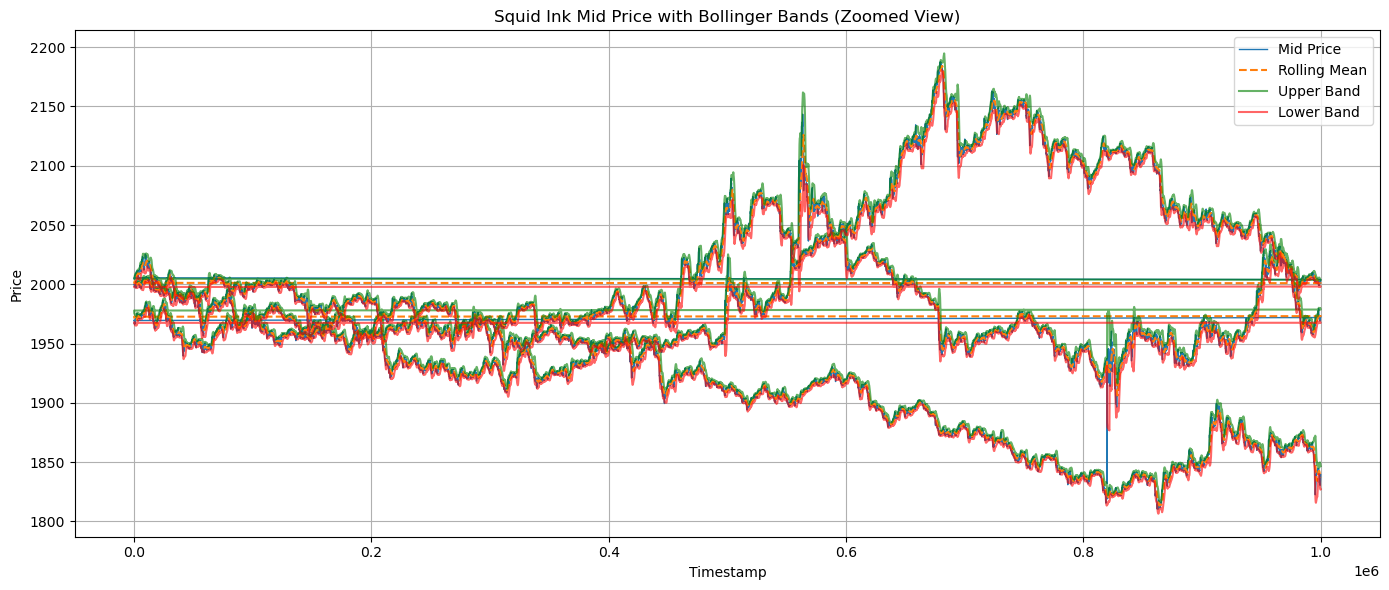

In [15]:
import matplotlib.pyplot as plt

# Step 1: Compute Bollinger Bands
window = 20
squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()
squid_df["upper_band"] = squid_df["rolling_mean"] + 2 * squid_df["rolling_std"]
squid_df["lower_band"] = squid_df["rolling_mean"] - 2 * squid_df["rolling_std"]

# Step 2: Plot mid price and Bollinger Bands
plt.figure(figsize=(14, 6))
plt.plot(squid_df["timestamp"], squid_df["mid_price"], label="Mid Price", linewidth=1)
plt.plot(squid_df["timestamp"], squid_df["rolling_mean"], label="Rolling Mean", linestyle="--")
plt.plot(squid_df["timestamp"], squid_df["upper_band"], label="Upper Band", color="green", alpha=0.6)
plt.plot(squid_df["timestamp"], squid_df["lower_band"], label="Lower Band", color="red", alpha=0.6)
plt.title("Squid Ink Mid Price with Bollinger Bands (Zoomed View)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


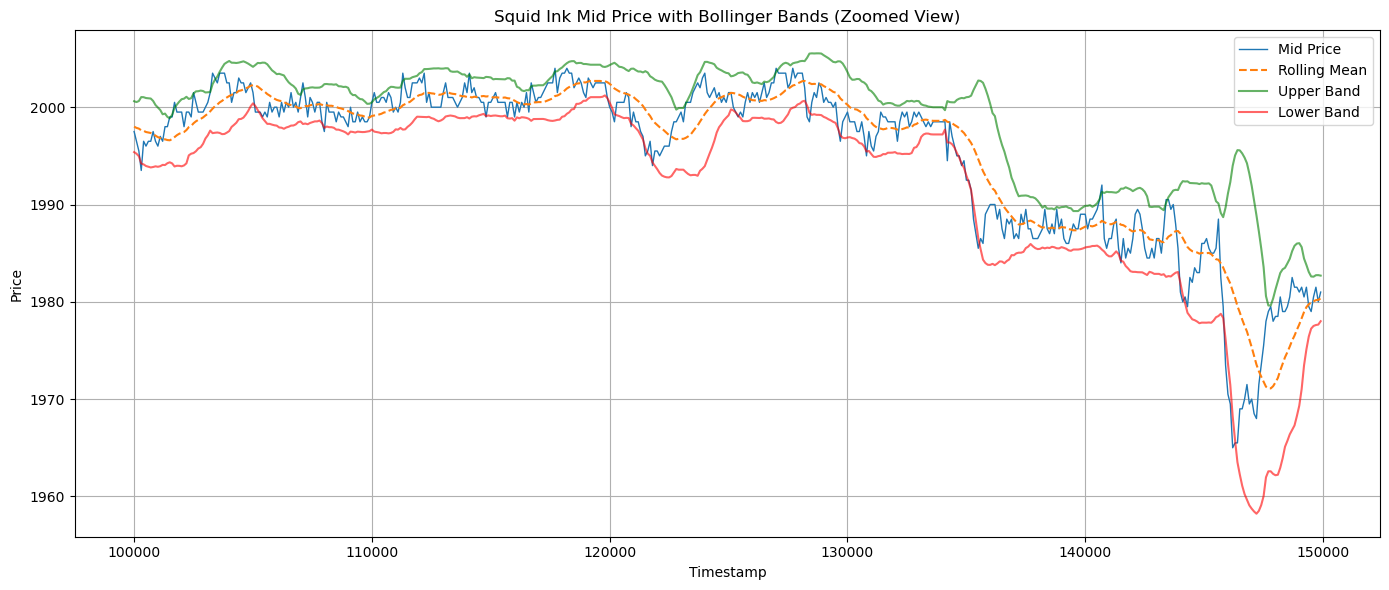

In [ ]:
# Plot a limited segment of the data to make the Bollinger Bands visually meaningful
subset = squid_df.iloc[1000:1500]

plt.figure(figsize=(14, 6))
plt.plot(subset["timestamp"], subset["mid_price"], label="Mid Price", linewidth=1)
plt.plot(subset["timestamp"], subset["rolling_mean"], label="Rolling Mean", linestyle="--")
plt.plot(subset["timestamp"], subset["upper_band"], label="Upper Band", color="green", alpha=0.6)
plt.plot(subset["timestamp"], subset["lower_band"], label="Lower Band", color="red", alpha=0.6)
plt.title("Squid Ink Mid Price with Bollinger Bands (Zoomed View)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [17]:
# Step 3: Simulate the strategy
position = 0
entry_price = 0
pnl = []

for i, row in squid_df.iterrows():
    price = row["mid_price"]
    upper = row["upper_band"]
    lower = row["lower_band"]
    mean = row["rolling_mean"]

    if pd.isna(upper) or pd.isna(lower):
        pnl.append(0)
        continue

    # Entry signals
    if position == 0:
        if price < lower:
            position = 1
            entry_price = price
        elif price > upper:
            position = -1
            entry_price = price
        pnl.append(0)
    
    # Exit signals
    elif position == 1:  # Long position
        if lower <= price <= upper:
            profit = price - entry_price
            pnl.append(profit)
            position = 0
        else:
            pnl.append(0)
    
    elif position == -1:  # Short position
        if lower <= price <= upper:
            profit = entry_price - price
            pnl.append(profit)
            position = 0
        else:
            pnl.append(0)

# Step 4: Analyze performance
squid_df["strategy_pnl"] = pnl
squid_df["cumulative_pnl"] = squid_df["strategy_pnl"].cumsum()

# Return summary stats
total_trades = (squid_df["strategy_pnl"] != 0).sum()
total_profit = squid_df["strategy_pnl"].sum()
avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean()
win_rate = (squid_df["strategy_pnl"] > 0).sum() / total_trades

(total_trades, total_profit, avg_profit, win_rate)


(1559, 1017.5, 0.6526619627966646, 0.7767799871712636)

In [ ]:
import numpy as np

# Grid search ranges
window_range = range(3, 20, 1)
band_width_range = np.arange(.5, 2, .1)

# Store results
results = []

for window in window_range:
    # Compute rolling stats
    squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
    squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()
    
    for band_width in band_width_range:
        # Compute bands
        squid_df["upper_band"] = squid_df["rolling_mean"] + band_width * squid_df["rolling_std"]
        squid_df["lower_band"] = squid_df["rolling_mean"] - band_width * squid_df["rolling_std"]

        # Simulate strategy
        position = 0
        entry_price = 0
        pnl = []

        for i, row in squid_df.iterrows():
            price = row["mid_price"]
            upper = row["upper_band"]
            lower = row["lower_band"]

            if pd.isna(upper) or pd.isna(lower):
                pnl.append(0)
                continue

            # Entry
            if position == 0:
                if price < lower:
                    position = 1
                    entry_price = price
                elif price > upper:
                    position = -1
                    entry_price = price
                pnl.append(0)

            # Exit
            elif position == 1 and lower <= price <= upper:
                pnl.append(price - entry_price)
                position = 0
            elif position == -1 and lower <= price <= upper:
                pnl.append(entry_price - price)
                position = 0
            else:
                pnl.append(0)

        squid_df["strategy_pnl"] = pnl
        total_profit = squid_df["strategy_pnl"].sum()
        trades = (squid_df["strategy_pnl"] != 0).sum()
        win_rate = (squid_df["strategy_pnl"] > 0).sum() / trades if trades > 0 else 0
        avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean() if trades > 0 else 0

        results.append({
            "window": window,
            "band_width": band_width,
            "total_profit": total_profit,
            "trades": trades,
            "avg_profit": avg_profit,
            "win_rate": win_rate
        })

# Create DataFrame from results
results_df = pd.DataFrame(results)
results_df.to_csv("strategy_results.csv", index=False)

In [24]:
# load csv and display as df
results_df = pd.read_csv("strategy_results.csv")
results_df.head()
# Find the best parameters based on total profit
best_params = results_df.loc[results_df["total_profit"].idxmax()]
best_params

window             4.000000
band_width         0.900000
total_profit    3167.500000
trades          6032.000000
avg_profit         0.525116
win_rate           0.756300
Name: 95, dtype: float64

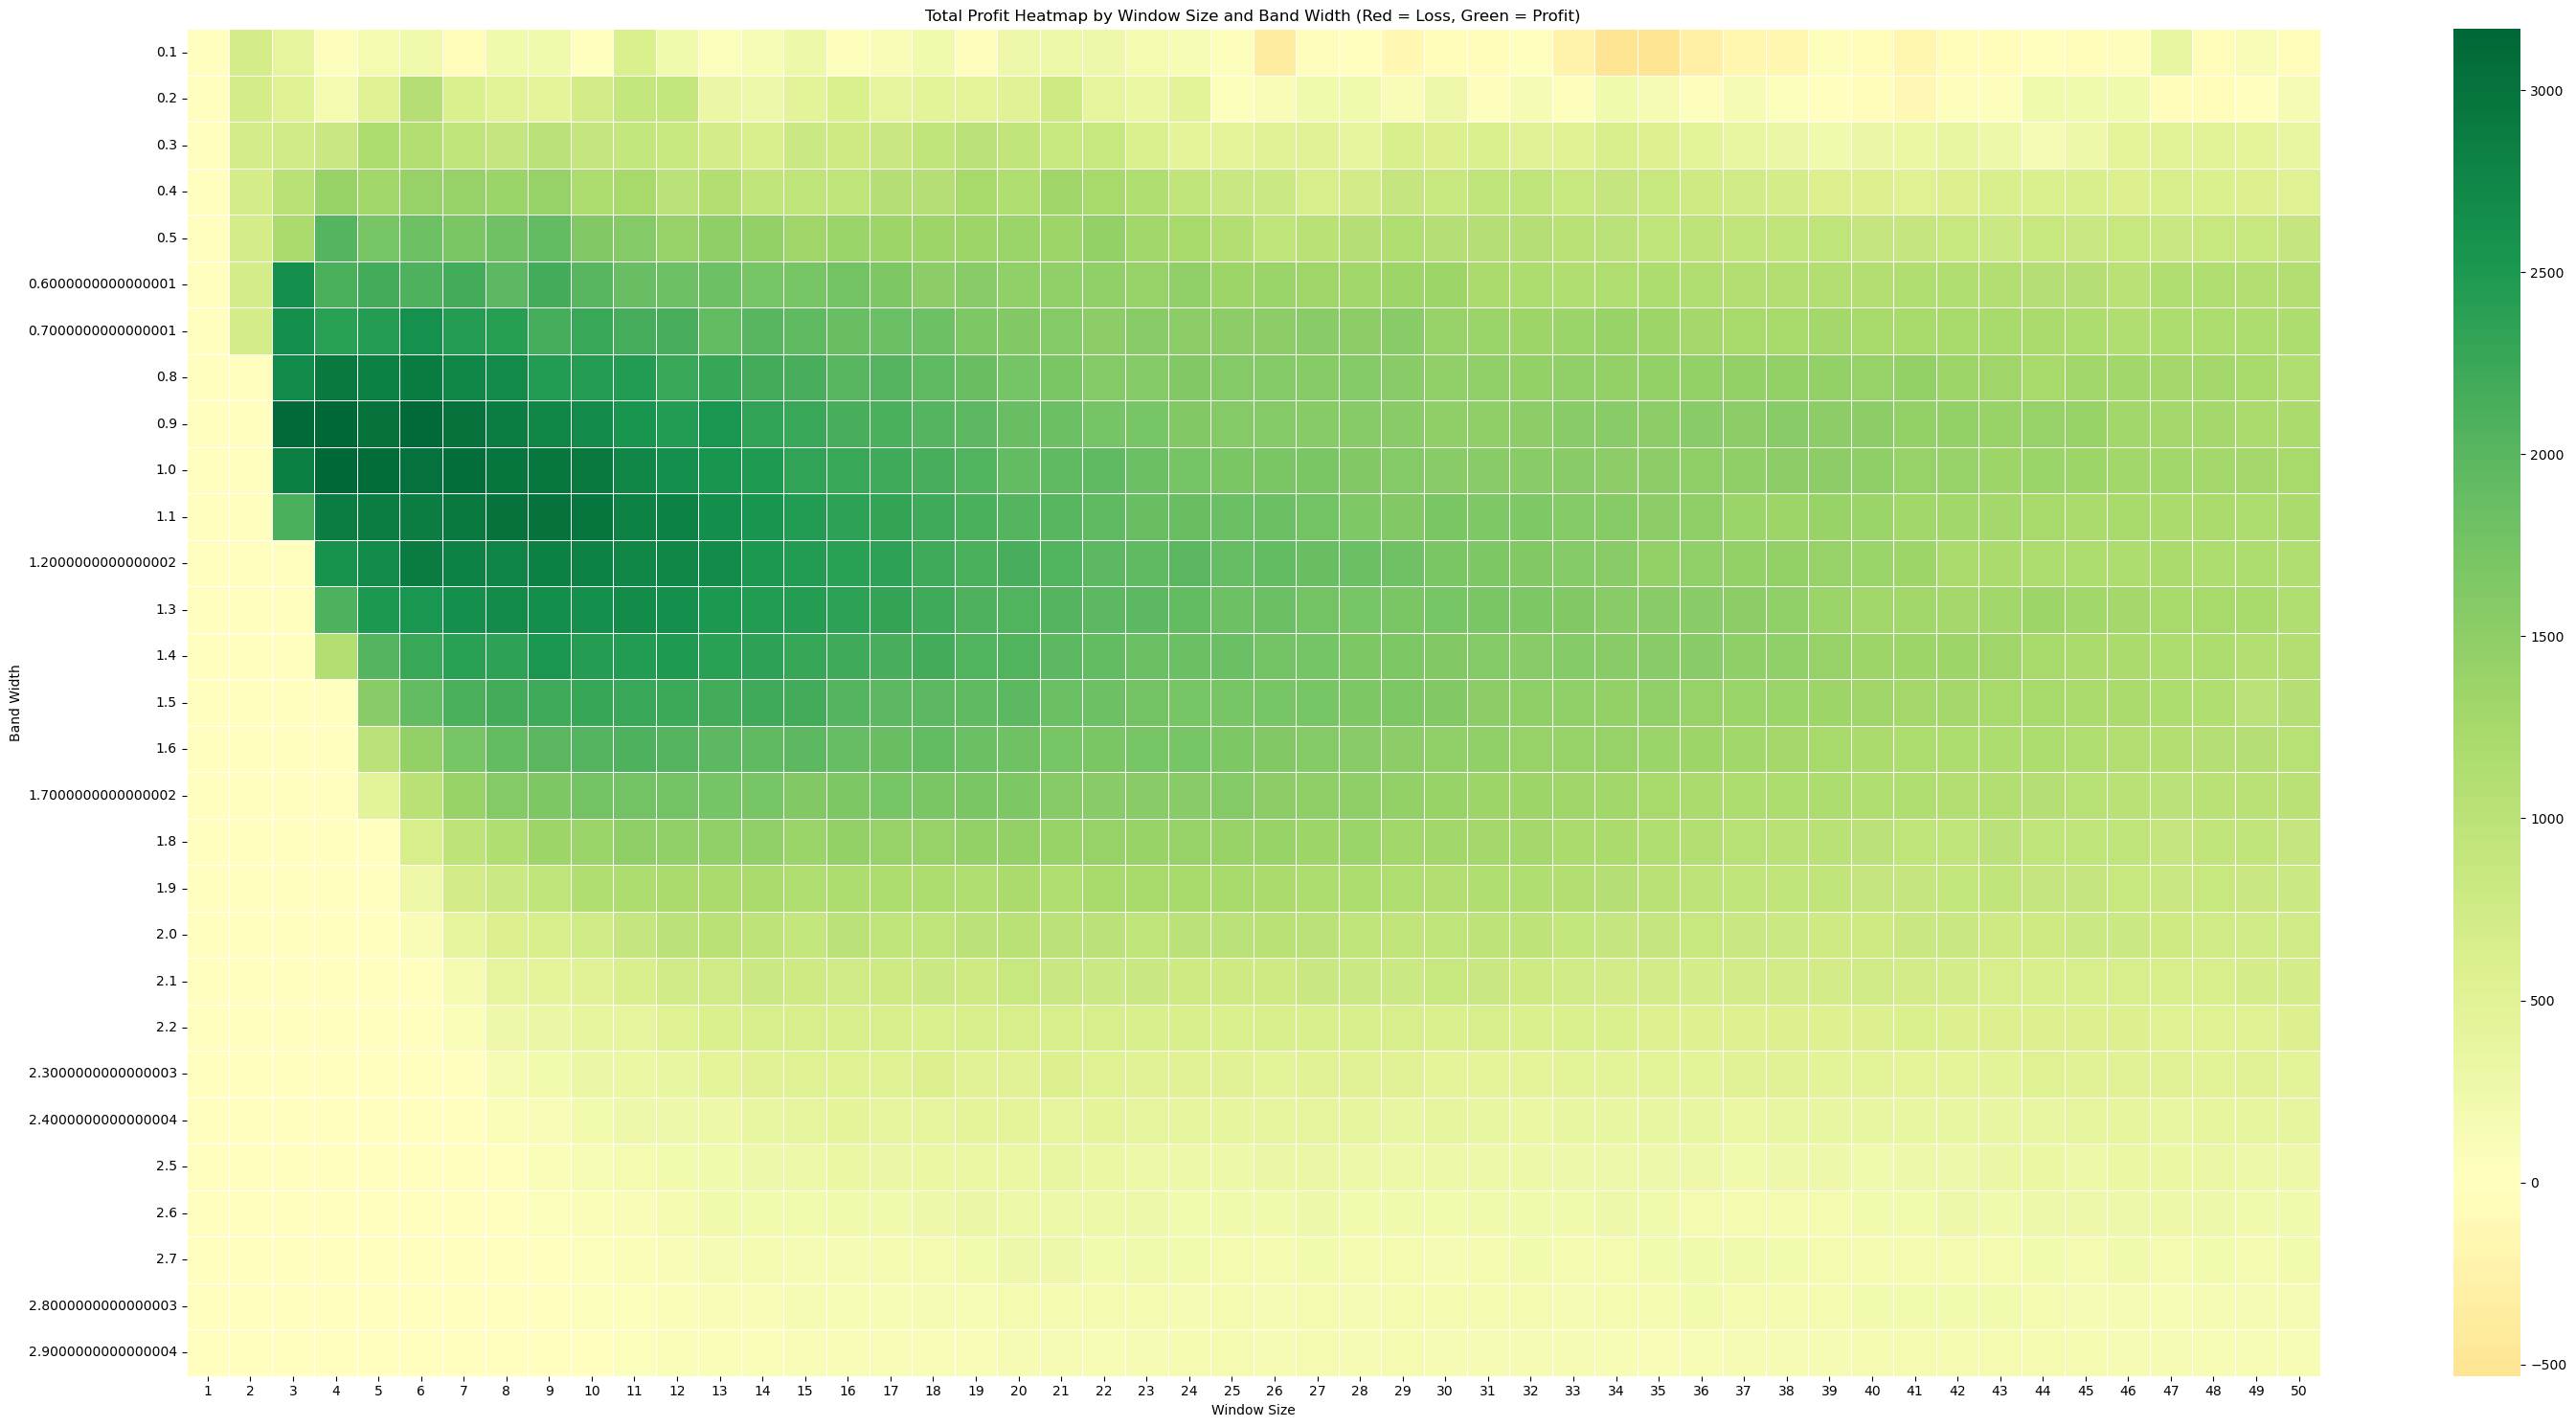

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table for heatmap (total profit as value)
heatmap_data = results_df.pivot(index="band_width", columns="window", values="total_profit")

plt.figure(figsize=(30, 15))
sns.heatmap(
    heatmap_data,
    annot=False,  # Disable text annotations
    cmap="RdYlGn",
    linewidths=0.5,
    center=0
)
plt.title("Total Profit Heatmap by Window Size and Band Width (Red = Loss, Green = Profit)")
plt.xlabel("Window Size")
plt.ylabel("Band Width")
plt.tight_layout()
plt.show()


In [6]:
# narrowed search with worse fills
# First, make sure relevant columns are numeric
import numpy as np
for col in ["bid_price_1", "ask_price_3"]:
    squid_df[col] = pd.to_numeric(squid_df[col], errors="coerce")

# Use best bid/ask prices for execution simulation
window_range = range(3, 200, 1)
band_width_range = np.arange(0.5, 3.0, 0.2)
results_bid_ask = []

for window in window_range:
    squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
    squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()

    for band_width in band_width_range:
        squid_df["upper_band"] = squid_df["rolling_mean"] + band_width * squid_df["rolling_std"]
        squid_df["lower_band"] = squid_df["rolling_mean"] - band_width * squid_df["rolling_std"]

        position = 0
        entry_price = 0
        pnl = []

        for i, row in squid_df.iterrows():
            bid = row["bid_price_1"]
            ask = row["ask_price_3"]
            upper = row["upper_band"]
            lower = row["lower_band"]
            mid = row["mid_price"]

            if pd.isna(upper) or pd.isna(lower) or pd.isna(bid) or pd.isna(ask):
                pnl.append(0)
                continue

            # Entry at market (best ask if long, best bid if short)
            if position == 0:
                if mid < lower:
                    position = 1
                    entry_price = ask  # buy at ask
                    pnl.append(0)
                elif mid > upper:
                    position = -1
                    entry_price = bid  # sell at bid
                    pnl.append(0)
                else:
                    pnl.append(0)

            # Exit at market
            elif position == 1 and lower <= mid <= upper:
                pnl.append(bid - entry_price)  # sell at bid
                position = 0
            elif position == -1 and lower <= mid <= upper:
                pnl.append(entry_price - ask)  # buy at ask
                position = 0
            else:
                pnl.append(0)

        squid_df["strategy_pnl"] = pnl
        total_profit = squid_df["strategy_pnl"].sum()
        trades = (squid_df["strategy_pnl"] != 0).sum()
        win_rate = (squid_df["strategy_pnl"] > 0).sum() / trades if trades > 0 else 0
        avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean() if trades > 0 else 0

        results_bid_ask.append({
            "window": window,
            "band_width": band_width,
            "total_profit": total_profit,
            "trades": trades,
            "avg_profit": avg_profit,
            "win_rate": win_rate
        })

# Create DataFrame from updated results and save
results_df_bid_ask = pd.DataFrame(results_bid_ask)
results_df_bid_ask.to_csv("shitfills.csv", index=False)

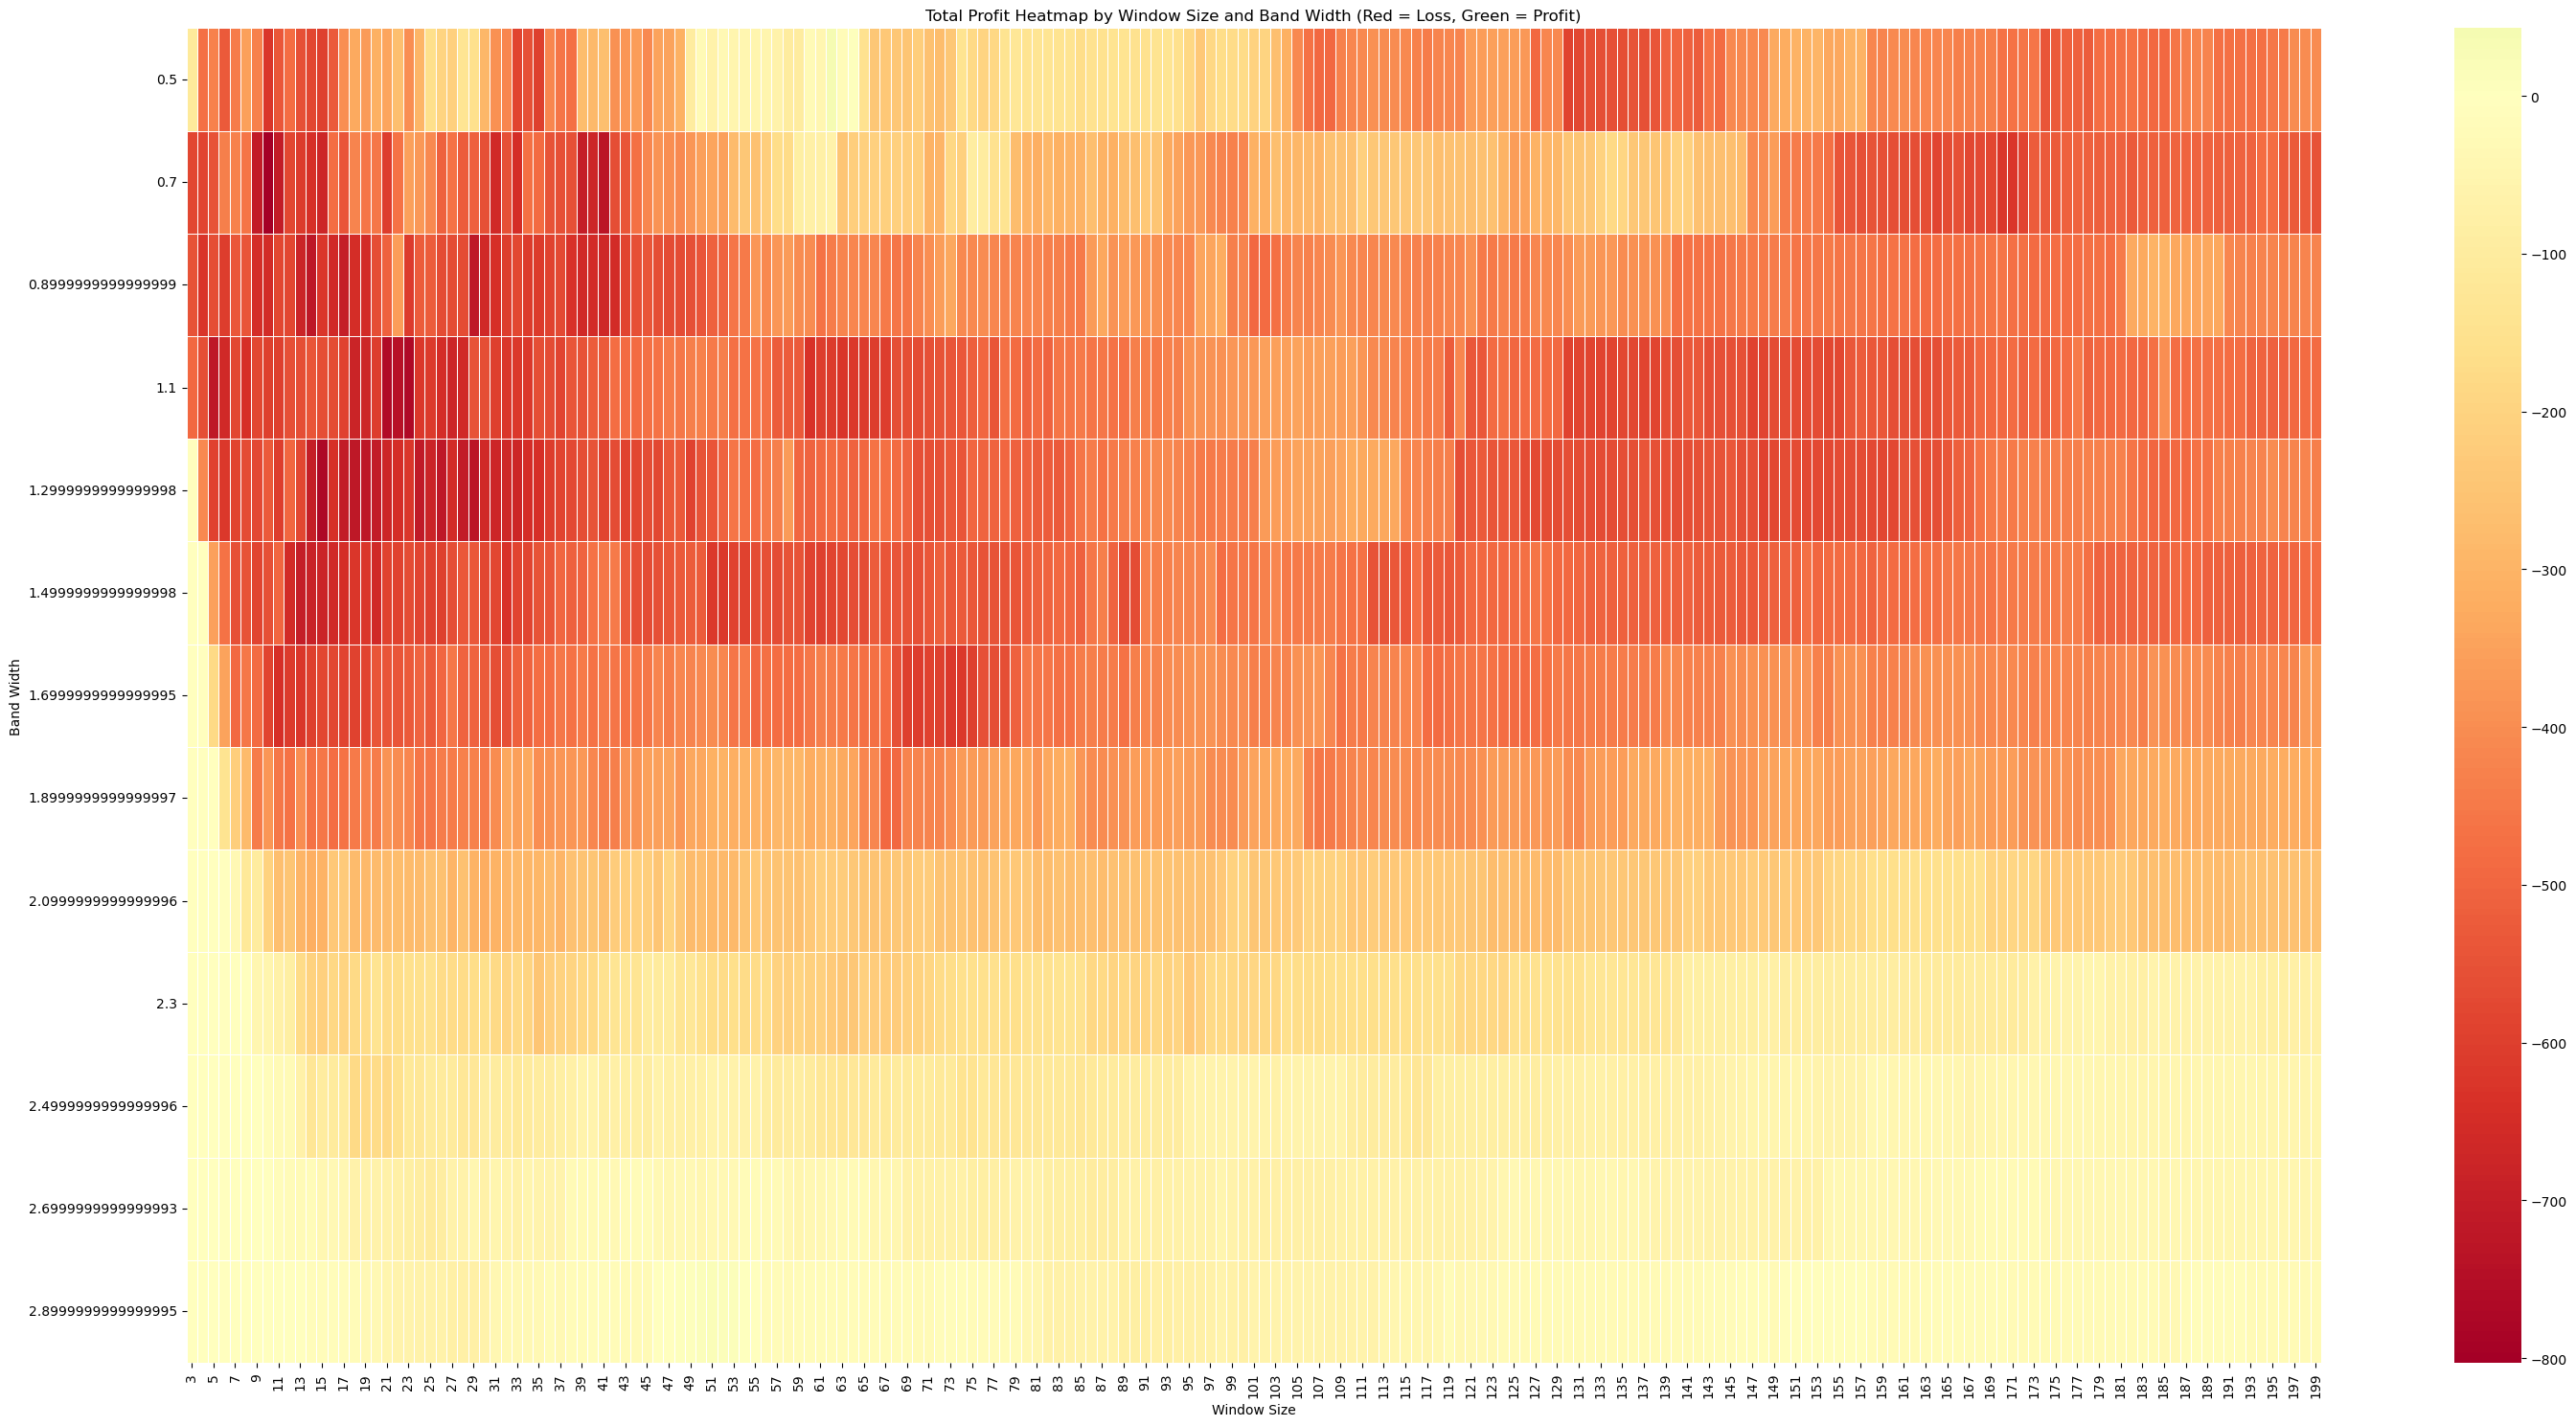

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table for heatmap (total profit as value)
# load csv 
results_df_bid_ask = pd.read_csv("shitfills.csv")
heatmap_data = results_df_bid_ask.pivot(index="band_width", columns="window", values="total_profit")

plt.figure(figsize=(30, 15))
sns.heatmap(
    heatmap_data,
    annot=False,  # Disable text annotations
    cmap="RdYlGn",
    linewidths=0.5,
    center=0
)
plt.title("Total Profit Heatmap by Window Size and Band Width (Red = Loss, Green = Profit)")
plt.xlabel("Window Size")
plt.ylabel("Band Width")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Make sure prices are numeric
for col in ["bid_price_1", "ask_price_3"]:
    squid_df[col] = pd.to_numeric(squid_df[col], errors="coerce")

window_range = range(3, 200, 1)
z_entry_range = np.arange(0.8, 2.5, 0.1)
z_exit_range = np.arange(0.1, 1.0, 0.2)
results_zscore = []

for window in window_range:
    squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
    squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()
    squid_df["zscore"] = (squid_df["mid_price"] - squid_df["rolling_mean"]) / squid_df["rolling_std"]

    for z_entry in z_entry_range:
        for z_exit in z_exit_range:
            position = 0
            entry_price = 0
            pnl = []

            for i, row in squid_df.iterrows():
                bid = row["bid_price_1"]
                ask = row["ask_price_3"]
                z = row["zscore"]

                if pd.isna(z) or pd.isna(bid) or pd.isna(ask):
                    pnl.append(0)
                    continue

                # Entry at market
                if position == 0:
                    if z < -z_entry:
                        position = 1
                        entry_price = ask  # Buy at ask
                        pnl.append(0)
                    elif z > z_entry:
                        position = -1
                        entry_price = bid  # Sell at bid
                        pnl.append(0)
                    else:
                        pnl.append(0)

                # Exit when z-score returns inside bounds
                elif position == 1 and -z_exit <= z <= z_exit:
                    pnl.append(bid - entry_price)  # Sell at bid
                    position = 0
                elif position == -1 and -z_exit <= z <= z_exit:
                    pnl.append(entry_price - ask)  # Buy at ask
                    position = 0
                else:
                    pnl.append(0)

            squid_df["strategy_pnl"] = pnl
            total_profit = squid_df["strategy_pnl"].sum()
            trades = (squid_df["strategy_pnl"] != 0).sum()
            win_rate = (squid_df["strategy_pnl"] > 0).sum() / trades if trades > 0 else 0
            avg_profit = squid_df["strategy_pnl"][squid_df["strategy_pnl"] != 0].mean() if trades > 0 else 0

            results_zscore.append({
                "window": window,
                "z_entry": round(z_entry, 2),
                "z_exit": round(z_exit, 2),
                "total_profit": total_profit,
                "trades": trades,
                "avg_profit": avg_profit,
                "win_rate": win_rate
            })

# Save results
results_df_zscore = pd.DataFrame(results_zscore)
results_df_zscore.to_csv("zscore_strategy.csv", index=False)


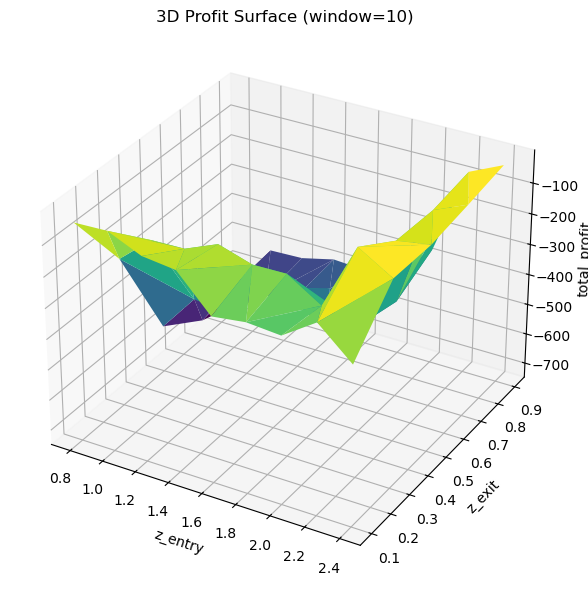

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table for heatmap (total profit as value)
# load csv 

from mpl_toolkits.mplot3d import Axes3D
fixed_window = 10
subset = results_df_zscore[results_df_zscore["window"] == fixed_window]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x = subset["z_entry"]
y = subset["z_exit"]
z = subset["total_profit"]

ax.plot_trisurf(x, y, z, cmap="viridis", edgecolor='none')
ax.set_title(f"3D Profit Surface (window={fixed_window})")
ax.set_xlabel("z_entry")
ax.set_ylabel("z_exit")
ax.set_zlabel("total_profit")
plt.tight_layout()
plt.show()


In [23]:

results_df_zscore = pd.read_csv("zscore_strategy.csv")
top_profit = results_df_zscore.sort_values("total_profit", ascending=False).head(10)
print(top_profit)

      window  z_entry  z_exit  total_profit  trades  avg_profit  win_rate
4580     104      2.2     0.1         522.0      17   30.705882  0.705882
4575     104      2.0     0.1         396.0      21   18.857143  0.619048
7760     175      1.6     0.1         389.0      24   16.208333  0.708333
1080      27      0.8     0.1         383.0      17   22.529412  0.588235
7715     174      1.6     0.1         367.0      21   17.476190  0.666667
770       20      1.0     0.1         365.0      25   14.600000  0.600000
765       20      0.8     0.1         353.0      25   14.120000  0.560000
1085      27      1.0     0.1         349.0      17   20.529412  0.529412
4256      97      1.8     0.3         340.0      36    9.444444  0.583333
4535     103      2.2     0.1         339.0      18   18.833333  0.666667


In [36]:
filtered = results_df_zscore[results_df_zscore["trades"] >= 10]
top_filtered = filtered.sort_values("total_profit", ascending=False).head(10)
print(top_filtered)


      window  z_entry  z_exit  total_profit  trades  avg_profit  win_rate  \
4580     104      2.2     0.1         522.0      17   30.705882  0.705882   
4575     104      2.0     0.1         396.0      21   18.857143  0.619048   
7760     175      1.6     0.1         389.0      24   16.208333  0.708333   
1080      27      0.8     0.1         383.0      17   22.529412  0.588235   
7715     174      1.6     0.1         367.0      21   17.476190  0.666667   
770       20      1.0     0.1         365.0      25   14.600000  0.600000   
765       20      0.8     0.1         353.0      25   14.120000  0.560000   
1085      27      1.0     0.1         349.0      17   20.529412  0.529412   
4256      97      1.8     0.3         340.0      36    9.444444  0.583333   
4535     103      2.2     0.1         339.0      18   18.833333  0.666667   

            score  
4580  1065.016982  
4575   757.746979  
7760   886.934410  
1080   651.183755  
7715   756.275054  
770    713.523142  
765    644.0

In [25]:
results_df_zscore["score"] = (
    results_df_zscore["total_profit"] * results_df_zscore["win_rate"] *
    np.log1p(results_df_zscore["trades"])  # Encourages more consistent setups
)

top_scores = results_df_zscore.sort_values("score", ascending=False).head(10)
print(top_scores)


      window  z_entry  z_exit  total_profit  trades  avg_profit  win_rate  \
4580     104      2.2     0.1         522.0      17   30.705882  0.705882   
7760     175      1.6     0.1         389.0      24   16.208333  0.708333   
4575     104      2.0     0.1         396.0      21   18.857143  0.619048   
7715     174      1.6     0.1         367.0      21   17.476190  0.666667   
4256      97      1.8     0.3         340.0      36    9.444444  0.583333   
770       20      1.0     0.1         365.0      25   14.600000  0.600000   
3645      84      0.8     0.1         329.0      24   13.708333  0.666667   
4445     101      2.2     0.1         330.0      19   17.368421  0.684211   
3665      84      1.6     0.1         322.0      25   12.880000  0.640000   
4535     103      2.2     0.1         339.0      18   18.833333  0.666667   

            score  
4580  1065.016982  
7760   886.934410  
4575   757.746979  
7715   756.275054  
4256   716.165386  
770    713.523142  
3645   706.0

In [46]:
# Step 1: Filter out windows with really bad profits (e.g. below -100)
filtered_results = results_df_zscore[results_df_zscore["total_profit"] > -1000]

# Step 2: Recalculate stability after removing bad windows
combo_stability = (
    filtered_results
    .groupby(["z_entry", "z_exit"])
    .agg(
        avg_profit=("total_profit", "mean"),
        std_profit=("total_profit", "std"),
        windows_tested=("window", "count"),
        min_profit=("total_profit", "min")
    )
    .sort_values("avg_profit", ascending=False)
)

print(combo_stability.head(10))


                avg_profit  std_profit  windows_tested  min_profit
z_entry z_exit                                                    
2.2     0.1     -61.010152  164.793067             197      -403.0
0.8     0.1     -64.847716  184.791629             197      -491.0
2.4     0.1     -65.736041  151.241061             197      -364.0
1.0     0.1     -72.380711  175.397660             197      -474.0
2.4     0.3     -77.771574  167.286488             197      -382.0
1.8     0.1     -89.512690  175.183158             197      -548.0
2.4     0.5     -90.025381  133.524684             197      -356.0
2.0     0.1     -95.421320  153.974422             197      -389.0
2.4     0.7     -97.025381  113.885300             197      -333.0
1.2     0.1     -99.000000  176.719685             197      -588.0


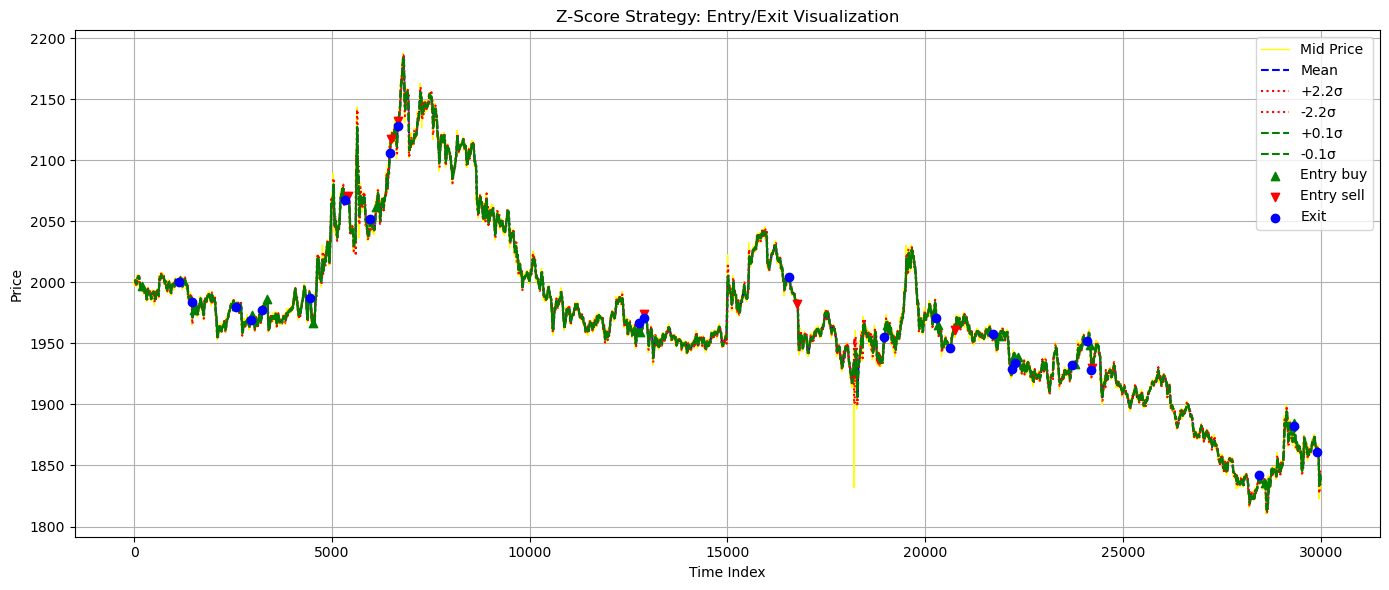

In [ ]:
import matplotlib.pyplot as plt

# First: Recompute zscore with chosen parameters
window = 20
z_entry = 1
z_exit = 0.1
squid_df = squid_df.iloc[1000:1500]
squid_df["rolling_mean"] = squid_df["mid_price"].rolling(window).mean()
squid_df["rolling_std"] = squid_df["mid_price"].rolling(window).std()
squid_df["zscore"] = (squid_df["mid_price"] - squid_df["rolling_mean"]) / squid_df["rolling_std"]

# === Mark trades ===
position = 0
entry_price = 0
entries = []
exits = []

for i, row in squid_df.iterrows():
    bid = row["bid_price_1"]
    ask = row["ask_price_3"]
    z = row["zscore"]

    if pd.isna(z) or pd.isna(bid) or pd.isna(ask):
        continue

    # Entry
    if position == 0:
        if z < -z_entry:
            position = 1
            entry_price = ask
            entries.append((i, ask, 'buy'))
        elif z > z_entry:
            position = -1
            entry_price = bid
            entries.append((i, bid, 'sell'))

    # Exit
    elif position == 1 and -z_exit <= z <= z_exit:
        exits.append((i, bid, 'sell'))
        position = 0
    elif position == -1 and -z_exit <= z <= z_exit:
        exits.append((i, ask, 'buy'))
        position = 0

# === Plot ===
plt.figure(figsize=(14, 6))
plt.plot(squid_df["mid_price"], label="Mid Price", color="yellow", linewidth=1)
plt.plot(squid_df["rolling_mean"], label="Mean", linestyle="--", color="blue")
plt.plot(squid_df["rolling_mean"] + z_entry * squid_df["rolling_std"], label="+2.2σ", linestyle=":", color="red")
plt.plot(squid_df["rolling_mean"] - z_entry * squid_df["rolling_std"], label="-2.2σ", linestyle=":", color="red")
plt.plot(squid_df["rolling_mean"] + z_exit * squid_df["rolling_std"], label="+0.1σ", linestyle="--", color="green")
plt.plot(squid_df["rolling_mean"] - z_exit * squid_df["rolling_std"], label="-0.1σ", linestyle="--", color="green")

# Plot trade entries
for i, price, side in entries:
    color = "green" if side == 'buy' else "red"
    plt.scatter(i, price, marker="^" if side == 'buy' else "v", color=color, label=f"Entry {side}", zorder=5)

# Plot trade exits
for i, price, side in exits:
    color = "blue"
    plt.scatter(i, price, marker="o", color=color, label=f"Exit", zorder=5)

# Prevent repeated legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

plt.title("Z-Score Strategy: Entry/Exit Visualization")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()
